In [1]:
import random
import torch

from utils.Logger import showPlot
from utils.Timer import asMinutes, timeSince

%load_ext autoreload
from data.exampleJP_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload


DATA_DIR = '_data_example'

## load data

In [2]:
# if True:    # 解凍する場合は True に書き換え
#     !mkdir  $DATA_DIR
#     %cd  $DATA_DIR

#     !git clone https://github.com/odashi/small_parallel_enja
#     !echo '------------------'
#     !head -n 5 small_parallel_enja/train.en
#     !head -n 5 small_parallel_enja/train.ja
#     !echo '------------------'

#     !ls
#     %cd ../

## setup Experiment

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup Data

In [4]:
input_lang, output_lang, pairs = prepareData(
    'en', 'ja', f'{DATA_DIR}/small_parallel_enja', False)

Reading lines...
Read 50000 sentence pairs
Counting words...
Counted words:
en 6637
ja 8777


In [5]:
print(random.choice(pairs))
print(input_lang.n_words, output_lang.n_words)

['father never hits me on the head .', '父 は 決して 私 の 頭 を たたか な い 。']
6637 8777


In [6]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

## setup Model

In [7]:
## Model
tokenizer = Seq2SeqTranslate_ptTokenizer(
                    input_lang, output_lang, device)

## setup Model

In [8]:
%load_ext autoreload
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
load_model_dir = '_best_weight_CPU'

In [10]:
emb_size = 1024
hidden_size = 1024

encoder = EncoderLSTM(input_lang.n_words, emb_size, hidden_size)
# encoder.load_weights(
#             load_m_dir=f'_logs/{load_model_dir}', 
#             load_m_file_name='encoder.pth')

## exec Evaluate

In [11]:
MAX_LENGTH = 18

decoder1 = AttnDecoderLSTM1(
                emb_size, hidden_size, output_lang.n_words, device)
decoder1.load_weights(
            load_m_dir=f'_logs/{load_model_dir}', 
            load_m_file_name='decoder_LSTM1.pth')

seq2seq_lstm1_model = Seq2Seq_batch_ptModel(
                            tokenizer, device,
                            dropout_p=0.1, max_length=MAX_LENGTH,
                            save_m_dir='_logs', 
                            save_m_file_names=(
                                'encoder.pth', 'decoder_LSTM1.pth'))
seq2seq_lstm1_model.set_models(encoder, decoder1)

[info] decoder_LSTM1.pth loaded !


In [12]:
# フォントを確認（日本語が入ると、文字化け（豆腐）になるかもなので）
# def show_avaiable_fonts():
#     print("Avaiable fonts:")
#     for font in mpl.font_manager.findSystemFonts():
#         fontname = mpl.font_manager.FontProperties(fname=font).get_name()
#         print(f"* {fontname}")

# # 利用可能なフォントを表示する。
# show_avaiable_fonts()

# !fc-list 

import matplotlib
# matplotlib.rcParams['font.family'] = 'IPAexGothic'
print(matplotlib.rcParams['font.family'])

['sans-serif']


> will you make up with me ?
= 私 と 仲直り し て くれ ま せ ん か 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



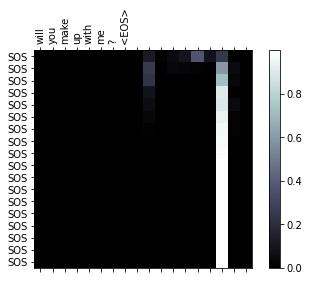

> his voice carries very well .
= 彼 の 声 は よく 通 る 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



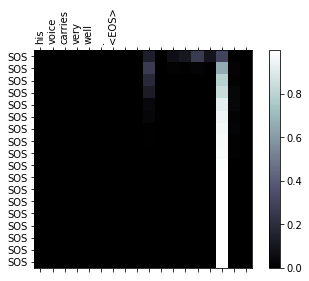

> this is the place where the battle took place .
= ここ が 、 その 戦い の あ っ た 所 で す 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



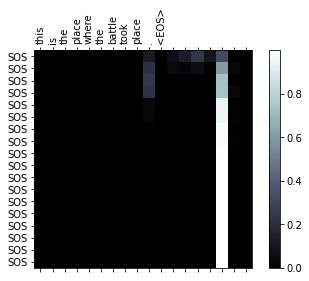

> i assumed that she was there .
= 私 は 当然 彼女 が そこ に い る と 思 っ た 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



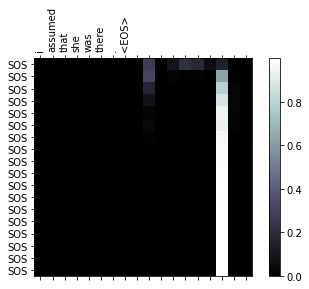

> she has a son and two daughters .
= 彼女 に は 男の子 １人 と 女の子 ２人 あ る 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



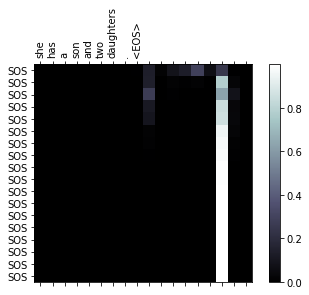

[0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
evaluate_batch_randomly(seq2seq_lstm1_model, test_pairs, n=5)

In [16]:
MAX_LENGTH = 18

attn_size = 1024
decoder2 = AttnDecoderLSTM2(
                emb_size, hidden_size, attn_size, 
                output_lang.n_words, device)
decoder2.load_weights(
            load_m_dir=f'_logs/{load_model_dir}', 
            load_m_file_name='decoder_LSTM2.pth')

seq2seq_lstm2_model = Seq2Seq_batch_ptModel(
                            tokenizer, device,
                            dropout_p=0.1, max_length=MAX_LENGTH,
                            save_m_dir='_logs', 
                            save_m_file_names=(
                                'encoder.pth', 'decoder_LSTM2.pth'))
seq2seq_lstm1_model.set_models(encoder, decoder2)

[info] decoder_LSTM2.pth loaded !


> he 's always running short of cash .
= 彼 は いつ も 現金 が 不足 し て い る 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



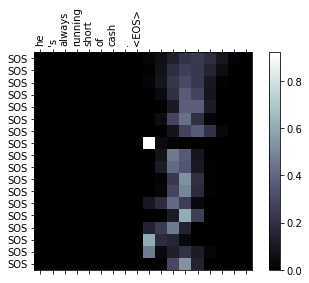

> ours is a mechanical age .
= 我々 の 時代 は 機械 時代 だ 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



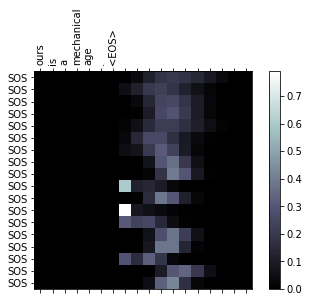

> she fed milk to the cat .
= 彼女 は その 猫 に 牛乳 を や っ た 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



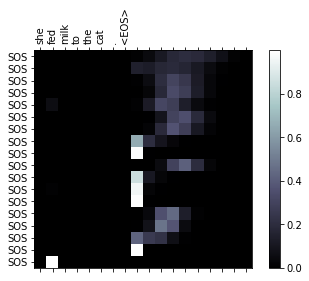

> a great change has come about after the war .
= 戦後 大きな 変化 が 生 じ た 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



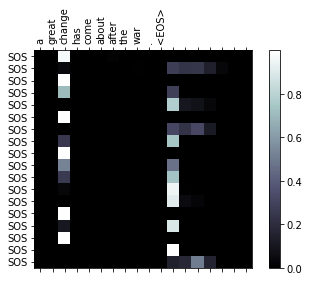

> i wish i could find one just like it .
= 私 も そう い う の が 欲し い で す 。
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
bleu: 0.0



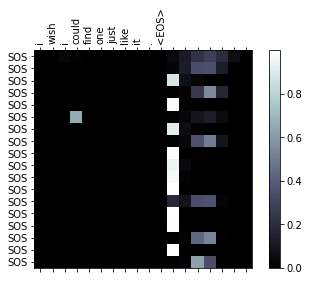

[0.0, 0.0, 0.0, 0.0, 0.0]

In [17]:
evaluate_batch_randomly(seq2seq_lstm1_model, test_pairs, n=5)